This is an attempt to collect data points for the BC547 transistor in the common emmitter configuration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols


In [2]:
from scipy import optimize


In [3]:
%matplotlib inline

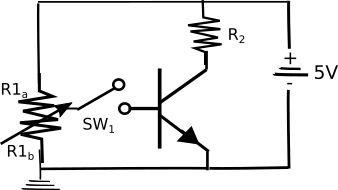

In this scenario we have a variable resistor pot VR1 (variable resistor 1) and a switch SW1 (which is a push down switch non-toggle switch).  R2 is a 1K resistor inline with the collector and supply. We measure the voltage across the variable terminal of R1, to it's middle terminal, with the switch open.  This allows us to calculate the selected impedance of VR1 with the switch open.  Then we close the switch and measure the voltage drop  at the middle terminal with the switch closed.  This in theory allows us to calculate the impedance of the base-emitter junction at the specified base voltage and therefore the base current.  VR1 is a 1K pot with the middle pin being some value between 0 and 1K ohms depending upon the knob position.

Going to model this against the Eber Molls equations ( or a simplified version of them from [Wikipedia](https://en.wikipedia.org/wiki/Bipolar_junction_transistor#Ebers%E2%80%93Moll_model) ).

$$ I_E = I_{ES} \left( e^{\frac{V_{BE}}{V_T}} \right) - 1 $$
$$ I_C = \alpha_F I_E $$
$$ I_B = ( 1 - \alpha_F ) I_E $$

Then I obtained by measurement the voltage at the middle pin of the variable resistor with the switch open, then the switch closed and finally the voltage at the collector of the transistor with the switch closed.  With my oscillopscope I measured the supply voltage at 4.96 volts but I take it to be 5 Volts for simplicity.  These measurements I put into an array called 'data'.

In [4]:
def plotRawData(data, prefix=None):
    fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(6,12))


    ax1.set_title('$V(open)$ vs $V(closed)$')

    ax1.scatter(data[:,0], data[:,1])
    ax1.grid()


    ax1.set_xlabel('$V_{open}$')
    ax1.set_ylabel('$V_{closed}$')

    ax2.set_title('$V(open)$ vs $V(collector)$')
    ax2.grid()

    ax2.scatter(data[:,0], data[:,2])


    ax3.set_title('$V(closed)$ vs $V(Collector)$')

    ax3.scatter(data[:,1], data[:,2])
    ax3.grid()


    ax3.set_xlabel('$V_{open}$')
    ax3.set_ylabel('$V_{closed}$')


    plt.tight_layout(pad=0.9)


In [5]:
def annotate(df, rcoll, extraR1a=0):
    supplyV = df.loc[:,'Vcoll'].max()
    maxvalue = 1e7
    #print (supplyV)
    
    df['R1b'] = (df['Vro'])/supplyV*(1000+extraR1a)
    df['R1a'] = (extraR1a+1000-df['R1b'])
    df['Rce'] = df.loc[:,'Vcoll']/supplyV*rcoll/(1-df.loc[:,'Vcoll']/supplyV)
    df['Rce'].replace(np.inf, maxvalue, inplace=True)

    # Compute the current going through R1_a as (Vcc - Vbe)/R1a
    # Then Reff is VBE/(current through R1_a), because Reff is R1b in parallel with 
    # base-emitter resistance
    # Reff is the effective resistance to ground from the centre pot with switch closed
    # Reff = R1_a * V_R1(closed) / (Vcc - V_R1(closed))
    df['Reff'] = df['R1a']*(df.loc[:,'Vrc'])/(supplyV- (df.loc[:,'Vrc']))
    df[abs(df['Reff'])>maxvalue]=maxvalue
    # Rbe is resistance calculcated for the base-emitter Junction
    df['Rbe'] = df['R1b']*df['Reff']/(df['R1b']-df['Reff'])
    df['Rbe'].replace(np.inf, maxvalue, inplace=True)
    # Ib is the base current calculated as base-emitter voltage divided by base-emitter resistance
    Ib = df.loc[:,'Vrc']/df['Rbe']
    # Ic is the collector current calculated accross resistor R2
    Ic = (supplyV - df.loc[:,'Vcoll'])/rcoll
    # Ie is the emmitter current which equals Ib + Ic
    Ie = Ib + Ic
    df['Ie']=Ie
    df['Ie (milliAmps)'] = Ie*1000
    df['Ib (microAmps)'] = Ib*1000000
    df['Ic (milliAmps)'] = Ic*1000
    df[ df < 0] = 0
    df.replace(np.inf, np.nan, inplace=True)
    df.dropna(axis=0, inplace=True)

In [6]:
data2k2a = np.array([[4.5,.912,.03],[4.36,.90,.03],[4.29, .90,.03],[4.2,.89, .03],
                     [4.07, .88, .02],[3.72,.87,.02],[3.21,.84, .02], [2.7,.82,.01],
                    [2.3,.81,.01], [1.97, .81, .01],[1.3, .77, .01],[1.46, .77,.01],
                    [1.15, .756, .01], [1.05, .748, .01],[.91, .731, .01],[.72, .69, .03],
                    [.69, .67, .05],[.59, .59, 4.51],[.61,.61,4.09],[.70, .68, .04],
                    [.73, .69,.03],[.65, .64, 1.69],[.66,.65,.10], [.64, .64, 1.5]])

In [7]:
data2k2asorted = data2k2a[data2k2a[:,0].argsort()]
df2k2a = pd.DataFrame(list(zip(*data2k2asorted))).T.astype(float)
df2k2a.columns = ('Vro', 'Vrc', 'Vcoll')
df2k2a.tail()

Vro    Vrc  Vcoll
19  4.07  0.880   0.02
20  4.20  0.890   0.03
21  4.29  0.900   0.03
22  4.36  0.900   0.03
23  4.50  0.912   0.03

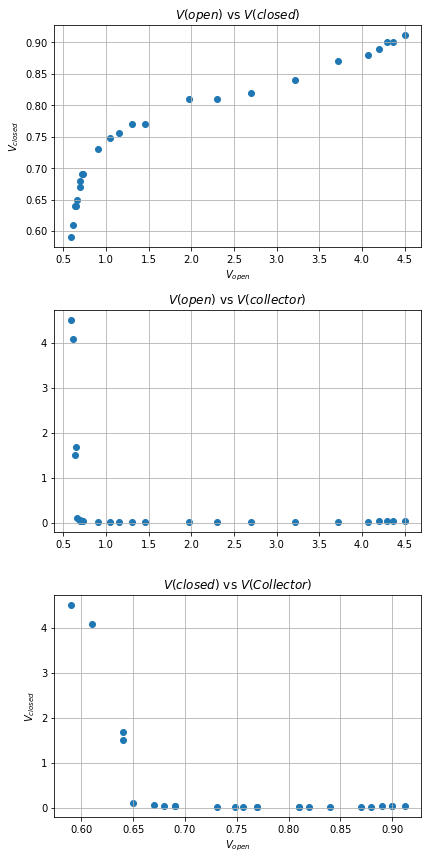

In [8]:
plotRawData(data2k2asorted)

In [9]:
data2k2b = np.array([[.624,.622,3.56],[.631, .630, 3.06], [.629,.628, 3.19],[.634, .629, .96],
                    [.660, .655, .28],[.64,.637,.81],[.624,.621,3.63],[.613, .613, 3.98],
                    [.602,.601,4.38],[5.99,5.99, 4.44],[.627,.626,3.42],[.656,.651,.51],
                    [.685,.662,.09],[.667,.659, .13],[.658, .656, .20],[.632,.627,.91]])

In [10]:
data2k2bsorted = data2k2b[data2k2b[:,0].argsort()][:-1]
df2k2b = pd.DataFrame(list(zip(*data2k2bsorted))).T.astype(float)
df2k2b.columns = ('Vro', 'Vrc', 'Vcoll')
df2k2b.tail()

Vro    Vrc  Vcoll
10  0.656  0.651   0.51
11  0.658  0.656   0.20
12  0.660  0.655   0.28
13  0.667  0.659   0.13
14  0.685  0.662   0.09

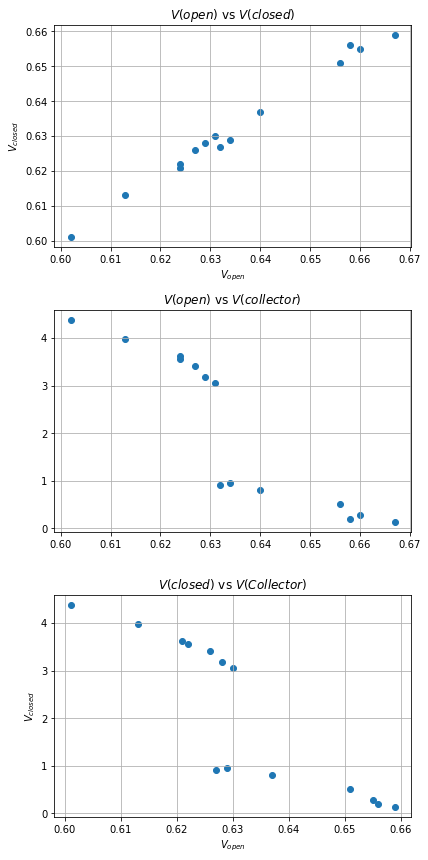

In [11]:
plotRawData(data2k2bsorted[:-1])

Now given we have a 1K pot I calculate the resistances of VR1<sub>a</sub> (the part of resistance connected to supply and the middle pin) and VR1<sub>b</sub> (the part of the variable resistance connected to ground and the middle pin)

In [12]:
def computeGain(df):
    ib = df['Ib (microAmps)'].head(10)
    ie = df['Ie (milliAmps)'].head(10)
    a = np.dot(ib, ie)/np.dot(ib, ib)
    return a*1000


In [13]:
def plotIbvsIeData(df, xlim=None, ylim=None):
    
    ax = df.plot('Ib (microAmps)', 'Ie (milliAmps)', kind='scatter', xlim=xlim, ylim=ylim)
    ax.set_title('$I_e$ vs $I_b$ with an npn BC547')
    ax.grid()
    #ax.plot(x,y)
    ax.set_ylabel('$I_e$ (mA)')
    ax.set_xlabel('$I_b$ ($\mu$A)')
    

In [14]:
def plotIbvsRbeData(df, xlim=None, ylim=None):
    ax = df.plot('Ib (microAmps)', 'Rbe', kind='scatter', xlim=xlim, ylim=ylim)
    ax.grid()
    ax.set_title('$R_{be}$ vs $I_b$ with an npn BC547')

    ax.set_ylabel('$R_{be}$ ($\Omega$)')
    ax.set_xlabel('$I_b$ ($\mu$A)')

    

In [15]:
def plotIbvsRceData(df, xlim=None, ylim=None):
    ax = df.plot('Ib (microAmps)', 'Rce', kind='scatter', xlim=xlim, ylim=ylim)
    ax.set_title('$R_{ce}$ vs $I_b$ with an npn BC547')

    ax.grid()
    #ax.plot(x,y)
    ax.set_ylabel('CE resistance ($\Omega$)')
    ax.set_xlabel('$I_b$ ($\mu$A)')




In [16]:
def plotVbevsIeData(df, xlim=None, ylim=None):
    ax = df.plot('Vrc', 'Ie (milliAmps)', kind='scatter', xlim=xlim, ylim=ylim)
    ax.set_title('$V_{be}$ vs $I_e$ with an npn BC547')

    ax.grid()
    #ax.plot(x,y)
    ax.set_ylabel('$I_E$ (mA)')
    ax.set_xlabel('$V_{BE}$')




In [17]:
annotate(df2k2a,2200)

In [18]:
annotate(df2k2b, 2200, 5000)

In [19]:
df2k2a.tail()

Vro    Vrc  Vcoll         R1b        R1a        Rce       Reff  \
19  4.07  0.880   0.02  902.439024  97.560976   9.799555  23.651146   
20  4.20  0.890   0.03  931.263858  68.736142  14.732143  16.899217   
21  4.29  0.900   0.03  951.219512  48.780488  14.732143  12.161340   
22  4.36  0.900   0.03  966.740576  33.259424  14.732143   8.291823   
23  4.50  0.912   0.03  997.782705   2.217295  14.732143   0.562027   

          Rbe        Ie  Ie (milliAmps)  Ib (microAmps)  Ic (milliAmps)  
19  24.287678  0.038273       38.273274    3.623236e+04        2.040909  
20  17.211547  0.053746       53.745834    5.170947e+04        2.036364  
21  12.318837  0.075095       75.095210    7.305885e+04        2.036364  
22   8.363558  0.109646      109.646067    1.076097e+05        2.036364  
23   0.562344  1.623820     1623.820337    1.621784e+06        2.036364

In [20]:
df2k2b.tail()

Vro    Vrc  Vcoll         R1b          R1a         Rce        Reff  \
10  0.656  0.651   0.51  898.630137  5101.369863  289.922481  890.585085   
11  0.658  0.656   0.20  901.369863  5098.630137  105.263158  898.147521   
12  0.660  0.655   0.28  904.109589  5095.890411  150.243902  896.055898   
13  0.667  0.659   0.13  913.698630  5086.301370   67.294118  900.798872   
14  0.685  0.662   0.09  938.356164  5061.643836   46.153846  901.239435   

              Rbe        Ie  Ie (milliAmps)  Ib (microAmps)  Ic (milliAmps)  
10   99478.109964  0.001766        1.765635        6.544153        1.759091  
11  251234.417965  0.001903        1.902611        2.611107        1.900000  
12  100591.480578  0.001870        1.870148        6.511486        1.863636  
13   63804.195948  0.001942        1.942147       10.328474        1.931818  
14   22784.431508  0.001979        1.979055       29.054927        1.950000

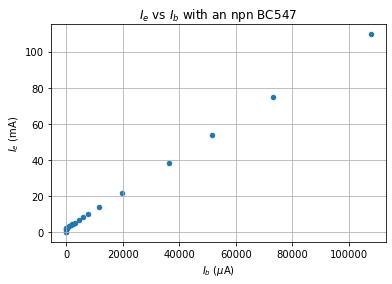

In [21]:
plotIbvsIeData(df2k2a[:-1])

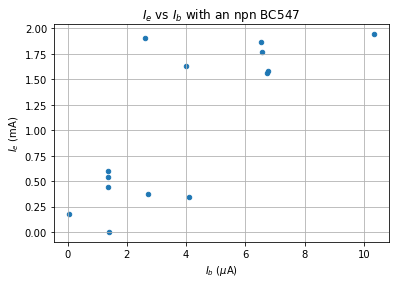

In [22]:
plotIbvsIeData(df2k2b[:-1])

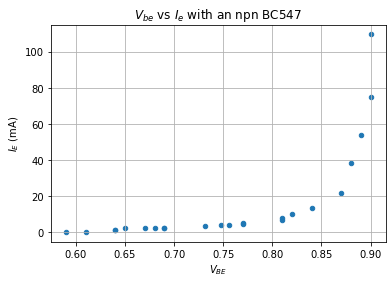

In [23]:
plotVbevsIeData(df2k2a[:-1])

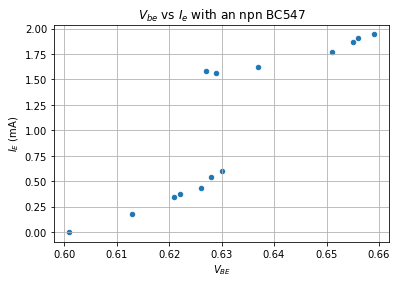

In [24]:
plotVbevsIeData(df2k2b[:-1])

In [25]:
df2k2 = df2k2a.append(df2k2b).sort_values('Vro')
# Remove an outlier
df2k2 = df2k2[:-1]

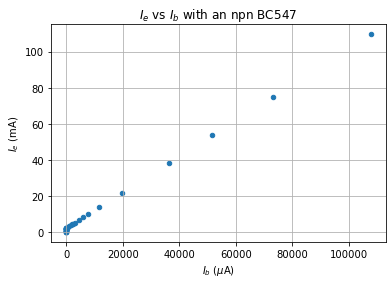

In [26]:
plotIbvsIeData(df2k2)

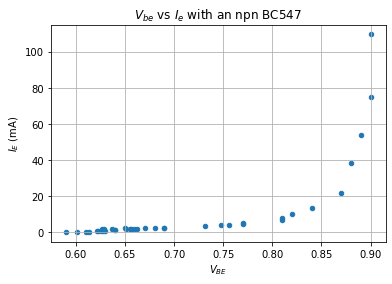

In [27]:
plotVbevsIeData(df2k2)

In [28]:
optimize.curve_fit

<function scipy.optimize.minpack.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)>

In [29]:
def fn(x, Is, vt ):
    return Is*(np.exp(x/vt)-1)

In [30]:
df2k2.columns

Index(['Vro', 'Vrc', 'Vcoll', 'R1b', 'R1a', 'Rce', 'Reff', 'Rbe', 'Ie',
       'Ie (milliAmps)', 'Ib (microAmps)', 'Ic (milliAmps)'],
      dtype='object')

In [31]:
popt,_ = optimize.curve_fit(fn, df2k2['Vrc'].to_numpy(), df2k2['Ie'].to_numpy(), p0=(1e-12, 0.0258))
is1, vt = popt
popt

array([4.37986205e-18, 2.39589154e-02])

Text(0.5, 1.0, '$y=Is ( e^{vbe/vt} -1)$')

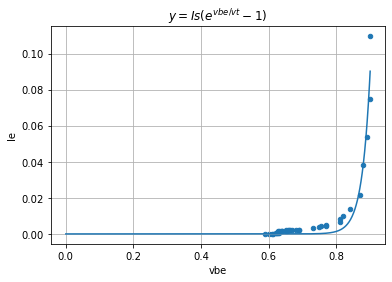

In [32]:
fig, ax = plt.subplots()
x = np.linspace(0,.9,1000 )
y = is1*(np.exp(x/vt)-1)
ax.plot(x,y)
df2k2.plot('Vrc', 'Ie', kind='scatter', ax=ax)
ax.grid()
ax.set_xlabel("vbe")
ax.set_ylabel("Ie")
ax.set_title("$y=Is ( e^{vbe/vt} -1)$")

In [33]:
df2k2a

Vro    Vrc  Vcoll         R1b         R1a           Rce        Reff  \
0   0.59  0.590   4.51  130.820399  869.179601  1.000000e+07  130.820399   
1   0.61  0.610   4.09  135.254989  864.745011  2.142381e+04  135.254989   
2   0.64  0.640   1.50  141.906874  858.093126  1.096346e+03  141.906874   
3   0.65  0.640   1.69  144.124169  855.875831  1.318440e+03  141.540189   
4   0.66  0.650   0.10  146.341463  853.658537  4.988662e+01  143.750790   
5   0.69  0.670   0.05  152.993348  847.006652  2.466368e+01  147.785015   
6   0.70  0.680   0.04  155.210643  844.789357  1.968680e+01  149.988711   
7   0.72  0.690   0.03  159.645233  840.354767  1.473214e+01  151.791830   
8   0.73  0.690   0.03  161.862528  838.137472  1.473214e+01  151.391324   
9   0.91  0.731   0.01  201.773836  798.226164  4.888889e+00  154.406808   
10  1.05  0.748   0.01  232.815965  767.184035  4.888889e+00  152.539516   
11  1.15  0.756   0.01  254.988914  745.011086  4.888889e+00  150.034199   
12  1.30  0.770   0.01  288.248337  711.751663  4.888889e+00  146.537107   
13  1.46  0.770   0.01  323.725055  676.274945  4.888889e+00  139.233077   
14  1.97  0.810   0.01  436.807095  563.192905  4.888889e+00  123.293582   
15  2.30  0.810   0.01  509.977827  490.022173  4.888889e+00  107.275124   
16  2.70  0.820   0.01  598.669623  401.330377  4.888889e+00   89.184528   
17  3.21  0.840   0.02  711.751663  288.248337  9.799555e+00   65.975096   
18  3.72  0.870   0.02  824.833703  175.166297  9.799555e+00   41.866670   
19  4.07  0.880   0.02  902.439024   97.560976  9.799555e+00   23.651146   
20  4.20  0.890   0.03  931.263858   68.736142  1.473214e+01   16.899217   
21  4.29  0.900   0.03  951.219512   48.780488  1.473214e+01   12.161340   
22  4.36  0.900   0.03  966.740576   33.259424  1.473214e+01    8.291823   
23  4.50  0.912   0.03  997.782705    2.217295  1.473214e+01    0.562027   

             Rbe            Ie  Ie (milliAmps)  Ib (microAmps)  Ic (milliAmps)  
0   6.021445e+17  9.798312e-19    9.798312e-16    9.798312e-13        0.000000  
1   1.000000e+07  1.909701e-04    1.909701e-01    6.100000e-02        0.190909  
2   0.000000e+00  1.368182e-03    1.368182e+00    0.000000e+00        1.368182  
3   7.894553e+03  1.362887e-03    1.362887e+00    8.106855e+01        1.281818  
4   8.120167e+03  2.084593e-03    2.084593e+00    8.004762e+01        2.004545  
5   4.341144e+03  2.181610e-03    2.181610e+00    1.543372e+02        2.027273  
6   4.458090e+03  2.184350e-03    2.184350e+00    1.525317e+02        2.031818  
7   3.085649e+03  2.259980e-03    2.259980e+00    2.236159e+02        2.036364  
8   2.340188e+03  2.331212e-03    2.331212e+00    2.948482e+02        2.036364  
9   6.577414e+02  3.156834e-03    3.156834e+00    1.111379e+03        2.045455  
10  4.423917e+02  3.736264e-03    3.736264e+00    1.690809e+03        2.045455  
11  3.645101e+02  4.119471e-03    4.119471e+00    2.074016e+03        2.045455  
12  2.980644e+02  4.628789e-03    4.628789e+00    2.583334e+03        2.045455  
13  2.443100e+02  5.197188e-03    5.197188e+00    3.151733e+03        2.045455  
14  1.717805e+02  6.760774e-03    6.760774e+00    4.715320e+03        2.045455  
15  1.358519e+02  8.007829e-03    8.007829e+00    5.962374e+03        2.045455  
16  1.047961e+02  9.870171e-03    9.870171e+00    7.824716e+03        2.045455  
17  7.271537e+01  1.359280e-02    1.359280e+01    1.155189e+04        2.040909  
18  4.410536e+01  2.176640e-02    2.176640e+01    1.972550e+04        2.040909  
19  2.428768e+01  3.827327e-02    3.827327e+01    3.623236e+04        2.040909  
20  1.721155e+01  5.374583e-02    5.374583e+01    5.170947e+04        2.036364  
21  1.231884e+01  7.509521e-02    7.509521e+01    7.305885e+04        2.036364  
22  8.363558e+00  1.096461e-01    1.096461e+02    1.076097e+05        2.036364  
23  5.623437e-01  1.623820e+00    1.623820e+03    1.621784e+06        2.036364

In [34]:
df2k2b 

Vro    Vrc  Vcoll         R1b          R1a           Rce        Reff  \
0   0.602  0.601   4.38  824.657534  5175.342466  1.000000e+07  823.069813   
1   0.613  0.613   3.98  839.726027  5160.273973  2.189000e+04  839.726027   
2   0.624  0.622   3.56  854.794521  5145.205479  9.551220e+03  851.601333   
3   0.624  0.621   3.63  854.794521  5145.205479  1.064800e+04  850.006013   
4   0.627  0.626   3.42  858.904110  5141.095890  7.837500e+03  857.305814   
5   0.629  0.628   3.19  861.643836  5138.356164  5.897479e+03  860.044688   
6   0.631  0.630   3.06  864.383562  5135.616438  5.100000e+03  862.783562   
7   0.632  0.627   0.91  865.753425  5134.246575  5.769452e+02  857.759820   
8   0.634  0.629   0.96  868.493151  5131.506849  6.175439e+02  860.495283   
9   0.640  0.637   0.81  876.712329  5123.287671  4.991597e+02  871.903352   
10  0.656  0.651   0.51  898.630137  5101.369863  2.899225e+02  890.585085   
11  0.658  0.656   0.20  901.369863  5098.630137  1.052632e+02  898.147521   
12  0.660  0.655   0.28  904.109589  5095.890411  1.502439e+02  896.055898   
13  0.667  0.659   0.13  913.698630  5086.301370  6.729412e+01  900.798872   
14  0.685  0.662   0.09  938.356164  5061.643836  4.615385e+01  901.239435   

             Rbe        Ie  Ie (milliAmps)  Ib (microAmps)  Ic (milliAmps)  
0   4.274998e+05  0.000001        0.001406        1.405849        0.000000  
1   1.000000e+07  0.000182        0.181879        0.061300        0.181818  
2   2.279678e+05  0.000375        0.375456        2.728455        0.372727  
3   1.517342e+05  0.000345        0.345002        4.092682        0.340909  
4   4.607056e+05  0.000438        0.437722        1.358785        0.436364  
5   4.634046e+05  0.000542        0.542264        1.355187        0.540909  
6   4.661100e+05  0.000601        0.601352        1.351612        0.600000  
7   9.290032e+04  0.001584        1.584022        6.749169        1.577273  
8   9.344169e+04  0.001561        1.561277        6.731470        1.554545  
9   1.589545e+05  0.001627        1.626735        4.007436        1.622727  
10  9.947811e+04  0.001766        1.765635        6.544153        1.759091  
11  2.512344e+05  0.001903        1.902611        2.611107        1.900000  
12  1.005915e+05  0.001870        1.870148        6.511486        1.863636  
13  6.380420e+04  0.001942        1.942147       10.328474        1.931818  
14  2.278443e+04  0.001979        1.979055       29.054927        1.950000